# SMC for a double normal likelihood with prior knowledge for the prior distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import cuda, float32, float64
import math
from scipy.stats import invgamma
import pandas as pd

@cuda.jit
def double_normal_log_likelihood(data,num_particles,mu1,sigma1,mu2,sigma2,w,out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    ##############################
    # sum for the log likelihood #
    log_likelihood = cuda.shared.array(shape=(8192,),dtype = np.float32)
    f_1 = cuda.shared.array(shape=(1,),dtype = np.float32)
    f_2 = cuda.shared.array(shape=(1,),dtype = np.float32)
    mix = cuda.shared.array(shape=(1,),dtype = np.float32)
    
    for i in range(0,data.shape[0]):
        f_1[0] =  w[start] * math.exp(-0.5 * ((data[i] - mu1[start])/ sigma1[start])**2 ) / (math.sqrt(2*math.pi*(sigma1[start]**2))) 
        f_2[0] = (1 - w[start]) * math.exp(-0.5 * ((data[i] - mu2[start])/ sigma2[start])**2 ) / (math.sqrt(2*math.pi*(sigma2[start]**2)))
        mix[0] = math.log(f_1[0] +  f_2[0]) 
            
        cuda.atomic.add(log_likelihood, start, mix[0])
        
    ##########################
   
    # likelihood function 
    out[start] = log_likelihood[start]

def SMC(data,num_particles,resampling_threshold,num_iterations):

    #############################
    # priors for the parameters #
    # mu1 
    prior_mean1 = np.float32(np.mean(data)); prior_std1 = np.float32(np.std(data))  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu1 = np.random.normal(prior_mean1, prior_std1, num_particles)  # Sample from the prior

    # simga1 
    alpha = np.float32(3.0) ; beta =  np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma1 = invgamma.rvs(a=alpha, scale=beta, size=num_particles)  # Sample from the prior

    # mu1 
    prior_mean2 = np.float32(np.mean(data)); prior_std2 = np.float32(np.std(data))  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu2 = np.random.normal(prior_mean2, prior_std2, num_particles)  # Sample from the prior

    # simga1 
    alpha2 = np.float32(3.0) ; beta2 = np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma2 = invgamma.rvs(a=alpha2, scale=beta2, size=num_particles)  # Sample from the prior

    # w 
    particles_w = np.random.beta(1, 1, num_particles)

    # CUDA arrays
    d_data = cuda.to_device(np.array(data,dtype=np.float32))
    # -----------

    #############################
    
    # Initialize particles and weights   
    weights = (np.ones(num_particles) / num_particles).astype(np.float32)  # Initial weights
    
    # SMC algorithm
    for t in range(1, num_iterations + 1):
        
        # CUDA arrays
        d_particles_mu1 = cuda.to_device(np.array(particles_mu1 ,dtype = np.float32))
        d_particles_sigma1 = cuda.to_device(np.array(particles_sigma1 ,dtype = np.float32))
        d_particles_mu2 = cuda.to_device(np.array(particles_mu2 ,dtype = np.float32))
        d_particles_sigma2 = cuda.to_device(np.array(particles_sigma2 ,dtype = np.float32))
        d_particles_w = cuda.to_device(np.array(particles_w ,dtype = np.float32))      
        d_out = cuda.device_array_like(d_particles_mu1)
        # -----------
        
        # Compute annealing temperature
        gamma = np.float32(t / num_iterations)  # Linearly increasing temperature

        # ---- Cuda function initializaion parametes ----- # 
        threads = 256 
        blocks = int(num_particles/threads) #num_particles/threads
        # ------------------------------------------------ #
        
        # Update weights
        double_normal_log_likelihood[blocks, threads](d_data,num_particles, d_particles_mu1, d_particles_sigma1, d_particles_mu2,d_particles_sigma2,d_particles_w,d_out)
        log_likelihood = np.array(d_out.copy_to_host())

        log_weights = np.log(weights) + gamma * log_likelihood
        
        log_weights -= np.max(log_weights)  # Normalize for numerical stability
        weights = np.exp(log_weights)

        weights /= np.sum(weights)  # Normalize weights
    
        # Effective sample size (ESS)
        ess = 1 / np.sum(weights**2)

        # Resampling step (if ESS is too low)
        if ess < resampling_threshold * num_particles:
            
            indices = np.random.choice(num_particles, size=num_particles, p=weights)
            particles_mu1 = particles_mu1[indices]
            particles_sigma1 = particles_sigma1[indices]
            particles_mu2 = particles_mu2[indices]
            particles_sigma2 = particles_sigma2[indices]
            particles_w = particles_w[indices]
            
            weights = (np.ones(num_particles) / num_particles).astype(np.float32)  # Reset weights

        # Propagation step (optional: add noise to particles)
        particles_mu1 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_sigma1 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_mu2 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_sigma2 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        
    # Final posterior approximation
    posterior_samples = pd.DataFrame({
        "mu1":particles_mu1,
        "sigma1":particles_sigma1,
        "mu2":particles_mu2,
        "sigma2":particles_sigma2,
        "w":particles_w,
        "weights":weights
    })

    return posterior_samples

# Reduce and transform the Lob data

In [2]:
# --------------------------------------------------------------- #
# calculate attributes from the lob data
# --------------------------------------------------------------- #

class calculate_attributes():
    
    def __init__(self,lob_data):
        self.data = lob_data
        self.timestamp = lob_data["timestamp"]
        self.bids = lob_data["bids"]
        self.asks = lob_data["asks"]
        self.reduce_lob()
        self.calculate_spread()
        self.calculate_LDispersion()

    def reduce_lob(self):
        # Aggregate data (e.g., calculate the sum of the volumes in a interval of prices)

        # asks #
        asks_prices = [item[0] for item in self.asks]
        asks_volumes = [item[1] for item in self.asks]

        data_asks = pd.DataFrame({"prices":asks_prices,"volume":asks_volumes})
        data_asks = data_asks.apply(pd.to_numeric)

        self.data_asks = data_asks

        ## asks bins ##
        iqr =  data_asks["prices"].quantile(0.75) - data_asks["prices"].quantile(0.25)
        h = 2*iqr*(len(asks_prices)**(-1/2))
        bins = round((max(data_asks["prices"])-min(data_asks["prices"]))/h)

        # create intervals #
        data_asks["interval"] = pd.cut(data_asks["prices"],bins = bins)
        self.agg_asks = data_asks.groupby("interval",observed=False).agg({"volume":["sum","mean","std"]})

        # Plot histogram of the aggregated values

        # bids #
        bids_prices = [item[0] for item in self.bids]
        bids_volumes = [item[1] for item in self.bids]

        data_bids = pd.DataFrame({"prices":bids_prices,"volume":bids_volumes})
        data_bids = data_bids.apply(pd.to_numeric)

        self.data_bids = data_bids

        ## bids bins ##
        iqr =  data_bids["prices"].quantile(0.75) - data_bids["prices"].quantile(0.25)
        h = 2*iqr*(len(bids_prices)**(-2/3))
        bins = round((max(data_bids["prices"])-min(data_bids["prices"]))/h)

        # create intervals #
        data_bids["interval"] = pd.cut(data_bids["prices"],bins = bins)
        self.agg_bids = data_bids.groupby("interval",observed=False).agg({"volume":["sum","mean","std"]})

    def return_agg_bids(self):
        return self.agg_bids

    def return_agg_ask(self):
        return self.agg_asks

    def calculate_spread(self):
        self.spread = round(float(self.asks[0][0]) - float(self.bids[0][0]),6)

    def calculate_LDispersion(self):

        ########
        ######## Order book dispersion:
        ########
        
        self.asks_total_volume = sum(self.data_asks["volume"])
        self.bids_total_volume = sum(self.data_bids["volume"])
        self.total_volume = self.asks_total_volume + self.bids_total_volume

        # bids
        price_bids_t1 = (self.data_bids[1:])["prices"]
        price_bids_t = (self.data_bids[:-1])["prices"]

        # asks
        price_asks_t1 = (self.data_asks[1:])["prices"]
        price_asks_t = (self.data_asks[:-1])["prices"]

        # weights:
        ## bids:

        bids_weights = (self.data_bids[1:])["volume"]/self.total_volume
        bids_weights = np.where(bids_weights == 0, 0.00001, bids_weights)

        Dst_bids = np.array(price_bids_t) - np.array(price_bids_t1)
        Dst_bids = np.where(Dst_bids == 0, 0.00001, Dst_bids)

        Dispersion_Bids_numerador = sum(bids_weights*Dst_bids)
        Dispersion_Bids_denominador = sum(bids_weights)

        if Dispersion_Bids_denominador == 0:
            Dispersion_Bids_denominador = 0.00001

        Dispersion_Bids = round(Dispersion_Bids_numerador/Dispersion_Bids_denominador,6)

        ## asks:

        asks_weights = (self.data_asks[1:])["volume"]/self.total_volume
        asks_weights = np.where(asks_weights == 0, 0.00001, asks_weights)

        Dst_asks = np.array(price_asks_t1) - np.array(price_asks_t)
        Dst_asks = np.where(Dst_asks == 0, 0.00001, Dst_asks)

        Dispersion_asks_numerador = sum(asks_weights*Dst_asks)
        Dispersion_asks_denominador = sum(asks_weights)
            
        if Dispersion_asks_denominador == 0:
            Dispersion_asks_denominador = 0.00001

        Dispersion_Asks = round(Dispersion_asks_numerador/Dispersion_asks_denominador,6)

        # LDispersion = (Dispersion_Bids + Dispersion_asks)/2
        LDispersion =  round((Dispersion_Bids + Dispersion_Asks)/2,6)

        self.Dispersion_Bids = Dispersion_Bids
        self.Dispersion_Asks = Dispersion_Asks
        self.LDispersion = LDispersion

    def return_statistics(self):
        return {"timestamp":self.timestamp,"spread":self.spread,"Agg bids":self.data_bids,"Agg asks":self.data_asks,
                           "bids total volume":self.bids_total_volume,"asks total volume":self.asks_total_volume,
                           "total volume":self.total_volume,"Bids dispersion":self.Dispersion_Bids,
                           "Asks dispersion":self.Dispersion_Asks,"LDispersion":self.LDispersion}


# Kafka Consumer with the estimation model

In [ ]:
import pandas as pd
import numpy as np
from pymongo.mongo_client import MongoClient
from datetime import datetime
import asyncio
import time
import math
import json
import uuid
from kafka import KafkaConsumer, KafkaProducer
import  sys 
import six
if sys.version_info >= (3, 12, 0):
    sys.modules['kafka.vendor.six.moves'] = six.moves


def operating_model(dataframe):
    ## ------------------ ##
    ## parameters for SMC ##
    num_particles = 8192  # Number of particles
    num_iterations = 200  # Number of intermediate distributions
    resampling_threshold = 0.5 # Resampling threshold (effective sample size fraction)

    ## ---- ##
    ## data ##
    data = np.array(dataframe["price"]).astype(np.float32)

    ## ------- ##
    ## run SMC ##
    posteriors = SMC(data,int(num_particles),resampling_threshold,num_iterations)
    solution = posteriors[posteriors["weights"] == np.max(posteriors["weights"])]
    #print(solution)

def main():

    ## ---------------------- ##
    ## read the kafka streams ##
    
    # Create a consumer instance
    consumer = KafkaConsumer(bootstrap_servers="localhost:9092")
    
    # Subscribe to the topic
    consumer.subscribe(['MatchTrades-data','Lob-data'])
    
    # create the dataframe for saving the data
    dataframe_MatchTrades = pd.DataFrame()
    
    try:
        while True:

            # listen to the kafka stream and save it to a variable
            msg = consumer.poll(0.1)

            if msg == {}:
                pass
    
            else:
                # get the kafka topic which the data came from
                for topic_partition, records in msg.items():
                    for record in records:
                        topic_name = record.topic  # Extracts 'MatchTrades-data'
                        print("Topic:", topic_name)

                # ------------ #
                # Match trades #
                if topic_name == 'MatchTrades-data':
                    
                    # transform the Consumer record to a dict
                    my_list = [elem[0] for elem in msg.values()] 
                    value_str = my_list[0].value.decode('utf-8')
                    value_dict = json.loads(value_str)
                    value_dict['amount'] = np.float32(value_dict['amount'])
                    value_dict['price'] = np.float32(value_dict['price'])

                    if (len(dataframe_MatchTrades) <= 6):
                        # save it the dataframe until it reaches length 32
                        dataframe_MatchTrades = pd.concat([dataframe_MatchTrades,pd.DataFrame([value_dict])],ignore_index=True)
                        
                    else:
                        # remove the first value and a ddd a new one to the end of the dataframe            
                        dataframe_MatchTrades = dataframe_MatchTrades.drop(0).reset_index(drop=True)
                        dataframe_MatchTrades = pd.concat([dataframe_MatchTrades,pd.DataFrame([value_dict])],ignore_index=True)

                        print(dataframe_MatchTrades)
                        ############################################
                        ##### function to run the dataframe in ##### 
                        # operating_model(dataframe)
                        
                # -------- #
                # Lob data #
                elif topic_name == 'Lob-data':
                    # transform the Consumer record to a dict
                    my_list = [elem[0] for elem in msg.values()] 
                    value_str = my_list[0].value.decode('utf-8')
                    value_dict = json.loads(value_str)
                    value_dict['bids'] = np.float32(value_dict['bids'])
                    value_dict['asks'] = np.float32(value_dict['asks'])

                    attr = calculate_attributes(value_dict)
                    print(attr.return_statistics())
                
    except KeyboardInterrupt:
        pass
    finally:
        consumer.close()


main()

Topic: MatchTrades-data
Topic: MatchTrades-data
Topic: MatchTrades-data
Topic: Lob-data
{'timestamp': 1743112243, 'spread': 0.015625, 'Agg bids':            prices   volume                interval
0    81077.617188  0.07059  (81057.535, 81077.617]
1    81077.148438  0.02174  (81057.535, 81077.617]
2    81074.976562  0.02181  (81057.535, 81077.617]
3    81072.898438  0.02241  (81057.535, 81077.617]
4    81072.867188  0.00571  (81057.535, 81077.617]
..            ...      ...                     ...
195  80483.437500  0.00017  (80474.546, 80495.231]
196  80480.000000  0.00024  (80474.546, 80495.231]
197  80476.546875  0.00069  (80474.546, 80495.231]
198  80475.210938  0.00007  (80474.546, 80495.231]
199  80475.148438  0.00051  (80474.546, 80495.231]

[200 rows x 3 columns], 'Agg asks':            prices   volume                interval
0    81077.632812  0.00021  (81077.282, 81101.029]
1    81089.437500  0.00010  (81077.282, 81101.029]
2    81093.046875  0.00410  (81077.282, 81101.029]
3

NameError: name 'norm' is not defined

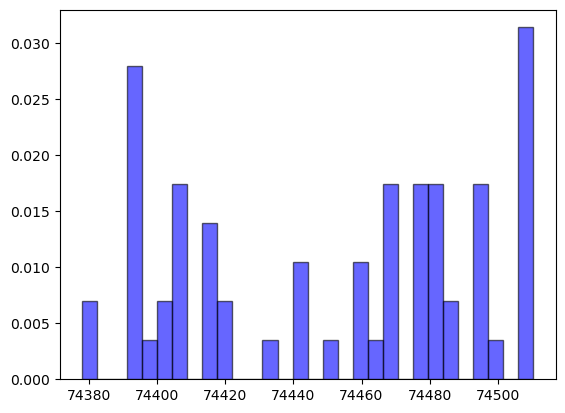

In [42]:
# Plot the histogram of the samples
plt.hist(dataframe["price"], bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')

# Overlay the theoretical PDF of the double normal distribution
x = np.linspace(-10, 15, 1000)
f1 = norm.pdf(x, mu1, sigma1)
f2 = norm.pdf(x, mu2, sigma2)
f = w * f1 + (1 - w) * f2  # Combined PDF
plt.plot(x, f, label='Double Normal PDF', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sampling from a Double Normal Distribution')
plt.legend()

# Show the plot
plt.show()